# Predicting News Article Popularity 

## Business Understanding 

Advertising on social media has empowered new and smaller media companies to publish textual content to a broader audience, which can then further spread their content. This presents the decision to make about which content to advertise or share in order to maximize the publisher’s reach. For even the smallest publishers, this decision can be supported with simple machine learning models analyzing content metadata. 

## Data Understanding 

In order to show how social media popularity for textual media can be modeled, article metadata was gathered from the New York Time's API website. Although one of the largest publishers of news articles, the data is of very high quality and should resemble what other companies have access to in-house. 

Two APIs were used. First, the __[NYT Archive API](https://developer.nytimes.com/docs/archive-product/1/overview)__,  which returns every article for a given range of months and years. Second, the __[NYT Most Popular API](https://developer.nytimes.com/docs/most-popular-product/1/overview)__, which returns the most popular articles on NYTimes.com based on emails, Facebook shares, or views on the NYT site. For this project Facebook shares were chosen and calls were made to the API once per day to gather that day's top 20 list. Articles in the archive that were listed on a top 20 list were then labeled as a popular article for a modeling target.  

#### Importing the required packages

In [1]:
# file manipulation 
import os

# data manipulation 
import re
import datetime as dt
import pandas as pd
import numpy as np
import math
from functions import *

# modeling 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_roc_curve

# sampling
from imblearn.over_sampling import SMOTE

# preprocessing text
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 


# plotting 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from wordcloud import WordCloud 
sns.set_context('notebook')

<br>

#### Loading the data
The scripts to request, clean and store both the article archive data and the daily top 20 most shared on Facebook lists can be found in [request_archive.py](./request_archive.py) and [request_most_shared_articles.py](./request_most_shared_articles.py). One request for a top 20 list for the previous 30 days was made to help label some articles in the archive as popular that were published before daily collection of a top 20 list was begun. 

The archive data contains all articles from December and all from January up to the end of the training phase on January 15th. Any rows with Null values in the archive were dropped and the date published column was changed to the datetime data type. The metadate that was collected for modeling was the headline of the article, keywords for the article, a snippet from the article and the word count for the article. Additionally the URI and date published was grabbed for each article. 

For each top 20 list the URI, date published and date the list was sourced was taken. 

In [2]:
# load archive articles from csv in data directory
df = pd.read_csv('data/archive_train.csv')
df.date_published = df.date_published.apply(lambda x: pd.to_datetime(x).date())
cutoff = pd.to_datetime('2022/01/08').date()
df = df[df.date_published >= cutoff]
df.dropna(inplace=True)

# load seperate top 20 lists in folder in data directory into single dataframe 
df_most_shared = load_most_shared('data/most_popular_train')

<br>
A list was made to house the URI's, the unique index for each article, for articles appearing on a top 20 list at least once. Then a popular column was created for the archive dataframe by iterating over the list of the highly shared articles and assigning a 0 if that article's URI was not present on the list and 1 for if it was. This is the target column for the models.

In [3]:
# create list, then interate over it to make target column
popular_list = df_most_shared.uri.values
df['popular'] = [1 if x in popular_list else 0 for x in df.uri.values]

In [4]:
# view the dataframe
df.head()

,uri,date_published,headline,keywords,snippet,word_count,popular
4764,nyt://article/4cc6765c-3935-595b-a0c0-209c81d6...,2022-01-08,5 big questions for the political year ahead,"united states politics and governmentbiden, jo...",Inflation and the pandemic are hurting Preside...,1460,0
4765,nyt://article/b6d1a470-eb88-555b-ab9a-a0ccfd69...,2022-01-08,officers ran off after firing stun gun that se...,"video recordings, downloads and streamingstun ...",The footage was released by New York’s attorne...,753,1
4766,nyt://article/263fa419-e2af-5fdc-9c27-8db5a68a...,2022-01-08,amy schneider becomes first woman to surpass $...,"game showsschneider, amy (1979- )jeopardy! (tv...","Schneider, a software engineering manager, is ...",410,0
4767,nyt://video/070a5c45-58b5-5e17-90ca-f8b55e55cbb4,2022-01-08,"sidney poitier, pioneering actor, dies at 94",actors and actressesacademy awards (oscars)dea...,Sidney Poitier was the first Black actor to wi...,0,0
4768,nyt://article/7f82d598-ab33-5f2f-abc9-3e4d1f87...,2022-01-08,ex-sheriff’s deputy pleads guilty in killing o...,"police brutality, misconduct and shootingscali...","Aaron Russell, 25, faces up to 11 years in pri...",503,0


## Exploratory Data Analysis  
Checking `df.info()` shows that both DataFrame individually have equal values with no Null values to take care of. It also shows that the datatypes are what we expect and want. 

In [5]:
print(df.info())
print()
print(df_most_shared.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 951 entries, 4764 to 5795
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             951 non-null    object
 1   date_published  951 non-null    object
 2   headline        951 non-null    object
 3   keywords        951 non-null    object
 4   snippet         951 non-null    object
 5   word_count      951 non-null    int64 
 6   popular         951 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 59.4+ KB
None

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 2022-01-18 to 2022-01-10
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             200 non-null    object
 1   date_published  200 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB
None


<br>
Checking `df.describe()` on a slice of the DataFrame with our features shows descriptive statistics on them. It shows that headlines are the shortest text feature, followed by keywords and then snippets. It also shows that the average for the word count column is 975.  

In [6]:
# creat copy of main DataFrame to run .describe() on
# convert text column to amount of words in value 
describe_df = df.copy()
describe_df = describe_df[['headline', 'keywords', 'snippet', 'word_count']]
describe_df.headline = describe_df.headline.apply(lambda x: len(x.split()))
describe_df.keywords = describe_df.keywords.apply(lambda x: len(x.split(',')))
describe_df.snippet = describe_df.snippet.apply(lambda x: len(x.split()))
describe_df.describe()

,headline,keywords,snippet,word_count
count,951.000000,951.000000,951.000000,951.000000
mean,9.293375,2.399579,21.286015,975.054679
std,2.722450,1.875089,6.689678,760.444047
min,1.000000,1.000000,3.000000,0.000000
25%,8.000000,1.000000,17.000000,555.500000
50%,10.000000,2.000000,22.000000,948.000000
75%,11.000000,3.000000,26.000000,1280.500000
max,19.000000,25.000000,42.000000,11424.000000


<br>

##### Archive articles
Looking at the distribution of article popularity reveals massive class imbalance. Only 2% of the articles in the archive appear on a top 20 list. This is particularly because of the articles included in the archive that were published in December and January before daily top 20 lists were started to be collected. Due to the API's constraints, only the daily top 20 list from the day the request was made are available. 

,sum,percentage
popular,,
0,834,0.88
1,117,0.12


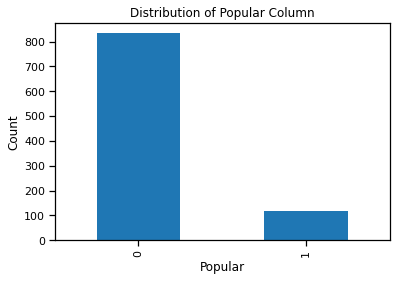

In [7]:
# function makes a dataframe to display target variable value's sum and percentage
# also, it plots the target variable's value distribution
target_distribution = summerize_value_counts(df.popular)
target_distribution

##### Top 20 most shared articles
Functions used to load, clean and plot date are found in [functions.py](./functions.py).


Looking at each day's top 20 list and the distribution of dates when the articles were published originally shows that the majority of the articles on each list were published in the two days before the day of the list's creation, with a smaller proportion having been published three days before or on the day of creation.

In [8]:
# load csv's into a list of dataframes 
df_list_load = load_most_shared_eda('data/most_popular_train')

# change date columns to datetime dtype and sort list by date of top 20 list in ascending order 
df_list = clean_most_shared_eda(df_list_load)

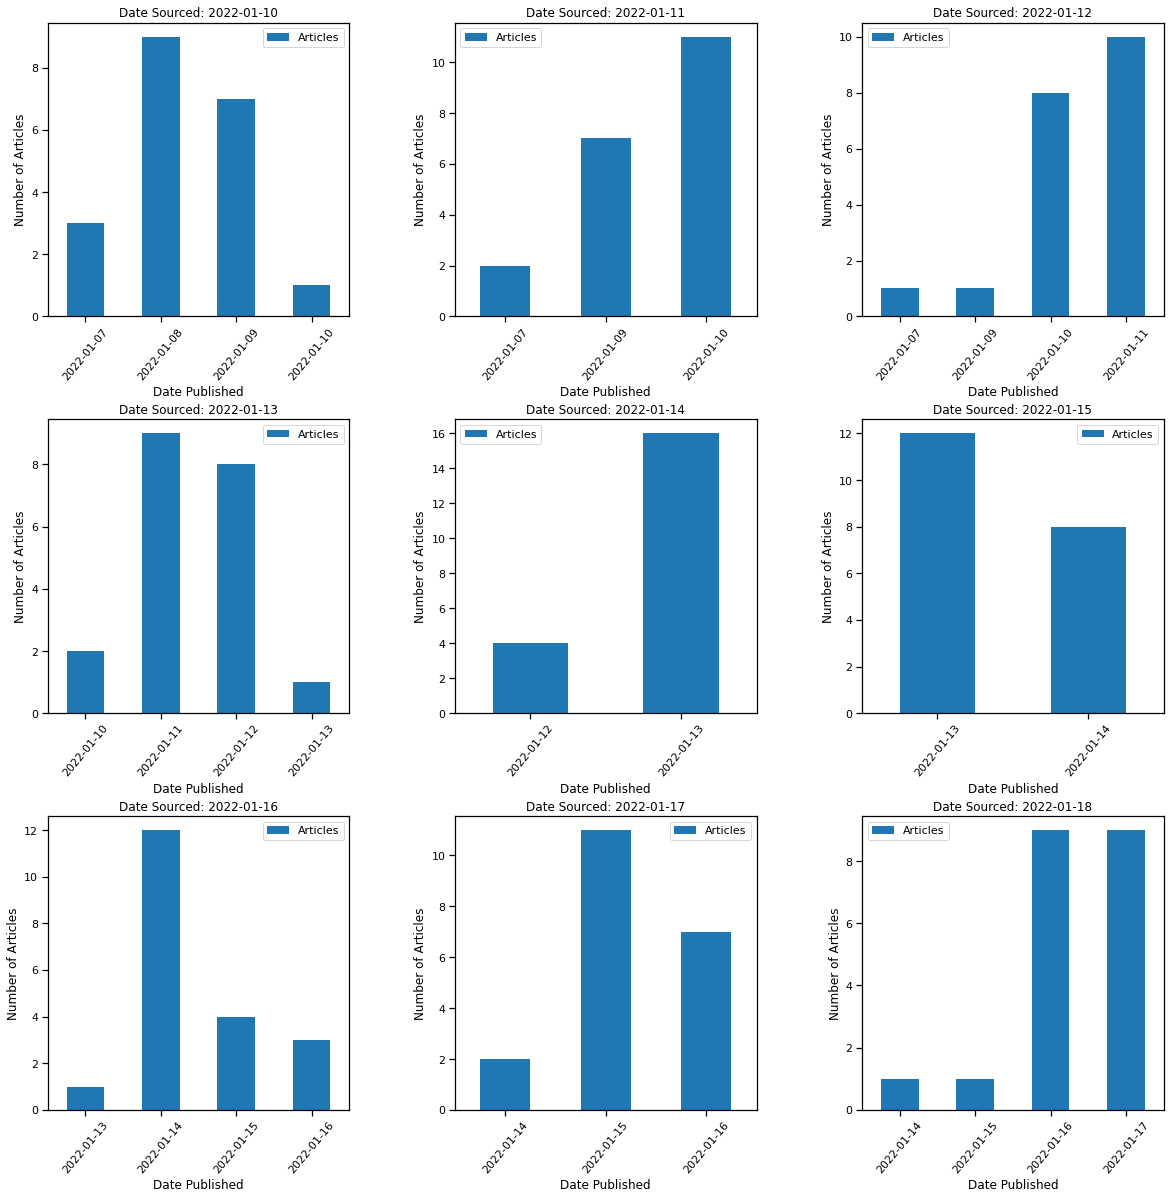

In [9]:
# generate correct amount of subplots based on length of list then plot each dataframe in list
plot_most_shared(df_list)

<br>
Distribution of days prior to Top 20 list that articles were published originally.

,percentage
0 days,3%
1 days,44%
2 days,45%
3 days,6%
4 days,2%
5 days,1%


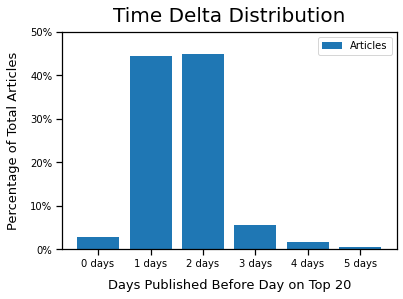

In [10]:
# function plots bar chart and returns values in Dataframe  
top_20_df = top_20_delta_perc(df_list)
top_20_df

<br>
Word Cloud for the headline's column. 

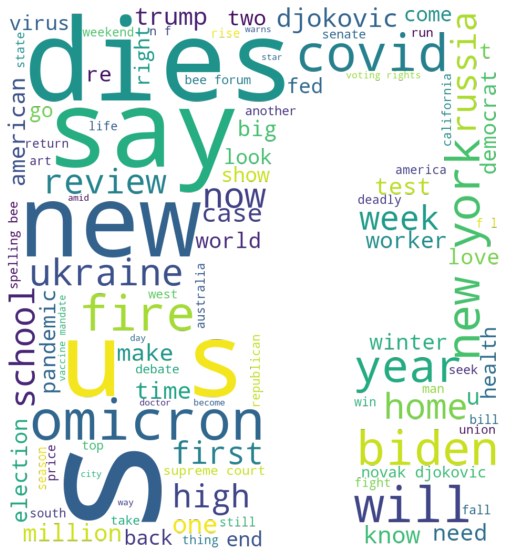

In [11]:
plot_word_cloud(df.headline, 'images/facebook.png')
plt.savefig('images/word_cloud.png');

## Data Preperation

##### Train-Test Split
Features are separated from the target and a test size of 40% is selected. This is because the final model is trained with the testing data results of the models before it. To ensure it has enough training data, a relatively high test size proportion was chosen. 

Also, the random state is established as 0, which will be the state for all models going forward. 

In [12]:
# features = X, target = y
X = df.drop('popular', axis=1)
y = df.popular

In [13]:
# random state of 0 is established for the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.40)

## Dummy classifier
A baseline model is established with the data.

In [14]:
# initialize baseline model
dummy = DummyClassifier(random_state=0, strategy='stratified') 

# fit with training data and predict with test set
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

In [15]:
# baseline model accuracy 
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.7900262467191601


In [16]:
# count how many articles are labeled popular by predicitng probabilities
dummy_prob = dummy.predict_proba(X_test)
dummy_predict_popular = [x[1] for x in dummy_prob if x[1] == 1]
len(dummy_predict_popular)

46

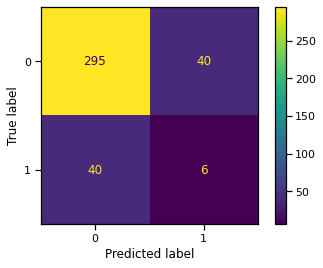

In [17]:
# plot confusion matrix to show error of the model
# 0: 'not popular', 1: 'popular'
plot_confusion_matrix(dummy, X_test, y_test);

The baseline model achieved a 95% accuracy rate, but this is due to the massive class imbalance towards articles that are not featured on the most shared list. The bottom right box in the confusion matrix shows that the baseline model correctly predicted  only 1 of the articles that were on a top 20 list.

<br>

## Data Preprocessing 

The following section will take care of both converting the textual data into numerical data and resampling the training data to address the class imbalance. This will be done separately for each feature, separating them and transforming the text features before every feature goes into their own model that will convert their values to numeric scores. After this they will eventually be rejoined in the final model for prediction of a top 20 list. 

The first differentiated preprocessing method for the textual data is how to tokenize each feature, or condense each string of text into a more meaningful version. Each of the features will be differentiated this way, with one similarity being the removal of stopwords. Stopwords are words that provide very little lexical context to a string of text based on their use in sentence construction. These words, such as "i", "me", "you", "isn't", and "wouldn't", will be removed in both of the different tokenized streams for the training data. At this point, one version of the data, the regular vectorizer, has completed tokenization. Another version will go through the extra step of lemmatization. This process' goal is to convert words in each string to a lexical stem with the help of the word's part of speech. This can combine words whose spelling differences are a reflection of being different inflected forms of the same word, rather than words with completely different meanings. This can help to further identify underlying patterns in the data. 


The second differentiated preprocessing method for the textual data, vectorizing each of the text features into a numeric matrix, will be done in two different ways for each of the two different tokenization methods, making four different streams for each of the three columns with text. This is in order to find the best preprocessing techniques for the final deployment pipelines. To differentiate vectorization, each feature will have one version go through a TfidfVectorizer and one version through a CountVectorizer. While both vectorizers transform the column of text data into a matrix where each column becomes a unique word that appears in the entire feature's column and each row a different article with numeric values under the words that appear in that article, they differ on how that numeric value is calculated. The CountVectorizer does so by  assigning a binary value of 0 and 1 to each word, where 0 indicates that the word does not appear in the article and a 1 indicates that it does. The TfidfVectorizer, on the other hand, assigns a floating point value to each word. This value is calculated by multiplying two different frequency measures together. The first measure is the words frequency in each feature of the article, or the amount of times it occurs in that article for that feature divided by the total amount of words in that feature for that article. This is then multiplied by the second measure, the Inverse Document Frequency, or the amount of articles there are in total divided by the amount of articles that contain that word for that feature.

After these preprocessing steps have occured, the class imbalance of the target variable, 'popular', is handled with SMOTE, Synthetic Minority Over-sampling Technique, resampling. This will resample the training data to include more data from the positive target class, meaning more articles that are labeled as having been featured on a top 20 most shared list will be included in order to better train the models to identify those articles. This will be done separately for each of the four distinct preprocessing methods that each of the three textual features go through. It is also the step where the fourth and final feature from the original dataset, 'word_count', is joined into this section as it is already in a numeric value that does not need any preprocessing.

### Headline

##### TfidfVectorizer

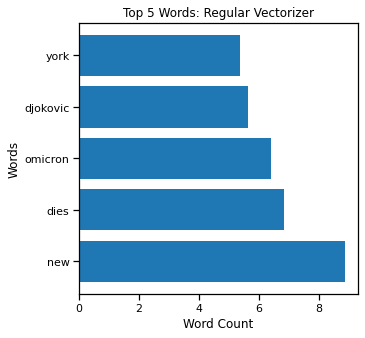

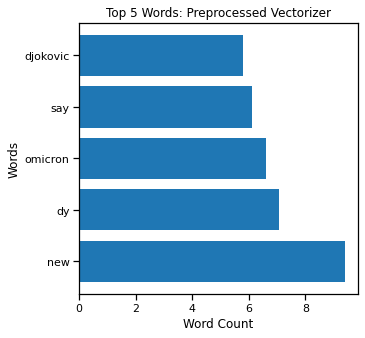

In [18]:
# regular vectorizer
headline_tf, X_train_headline_tf, X_test_headline_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.headline, X_test.headline)
# smote vectorized training data
X_train_headline_tf_sm, y_train_headline_tf_sm = smote_data(X_train_headline_tf, y_train,
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_tf
# data : X_train_headline_tf_sm, y_train_headline_tf_sm, X_test_headline_tf



# tokenize and lemmatize before vectorization
headline_tok_tf, X_train_headline_tok_tf, X_test_headline_tok_tf = tokenize_vector(TfidfVectorizer, 
                                                                                   X_train.headline, 
                                                                                   X_test.headline)
# smote preprocessed vectorized training data
X_train_headline_tok_tf_sm, y_train_headline_tok_tf_sm = smote_data(X_train_headline_tok_tf, y_train,
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_tok_tf
# data : X_train_headline_tok_tf_sm, y_train_headline_tok_tf_sm, X_test_headline_tok_tf

plot_top_words(headline_tf, X_train_headline_tf, 'Regular Vectorizer');
plot_top_words(headline_tok_tf, X_train_headline_tok_tf, 'Preprocessed Vectorizer');

##### CountVectorizer

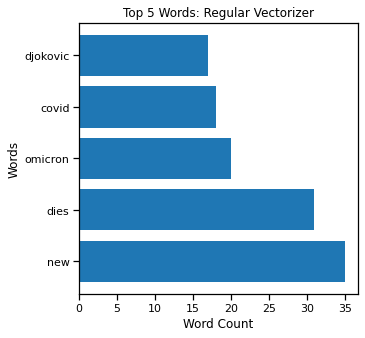

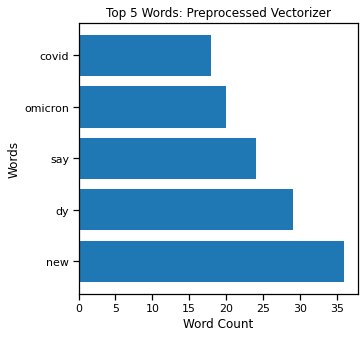

In [19]:
# regular vectorizer
headline_cv, X_train_headline_cv, X_test_headline_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.headline, X_test.headline)
# smote vectorized training data
X_train_headline_cv_sm, y_train_headline_cv_sm = smote_data(X_train_headline_cv, y_train, 
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_cv
# data: X_train_headline_cv_sm, y_train_headline_cv_sm, X_test_headline_cv



# tokenize and lemmatize before vectorization
headline_tok_cv, X_train_headline_tok_cv, X_test_headline_tok_cv = tokenize_vector(CountVectorizer, 
                                                                                   X_train.headline, 
                                                                                   X_test.headline)
# smote preprocessed vectorized training data
X_train_headline_tok_cv_sm, y_train_headline_tok_cv_sm = smote_data(X_train_headline_tok_cv, y_train,
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_tok_cv
# data: X_train_headline_tok_cv_sm, y_train_headline_tok_cv_sm, X_test_headline_tok_cv

plot_top_words(headline_cv, X_train_headline_cv, 'Regular Vectorizer');
plot_top_words(headline_tok_cv, X_train_headline_tok_cv, 'Preprocessed Vectorizer');

### Keywords

##### TfidfVectorizer

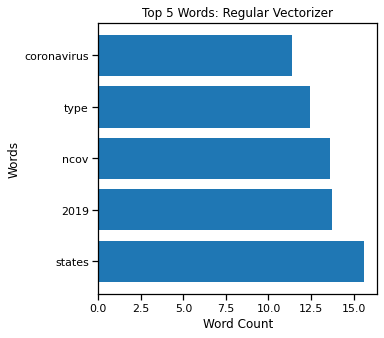

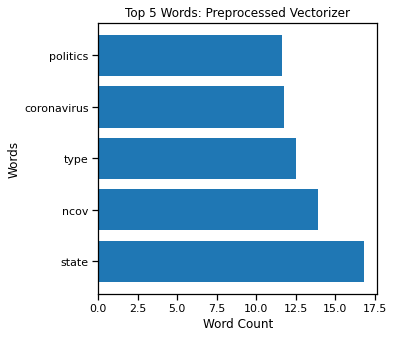

In [20]:
# regular vectorizer
keywords_tf, X_train_keywords_tf, X_test_keywords_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.keywords, X_test.keywords)
# smote vectorized training data
X_train_keywords_tf_sm, y_train_keywords_tf_sm = smote_data(X_train_keywords_tf, y_train, 
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_tf
# data: X_train_keywords_tf_sm, y_train_keywords_tf_sm, X_test_keywords_tf



# tokenize and lemmatize before vectorization
keywords_tok_tf, X_train_keywords_tok_tf, X_test_keywords_tok_tf = tokenize_vector(TfidfVectorizer, 
                                                                                   X_train.keywords, 
                                                                                   X_test.keywords)
# smote preprocessed vectorized training data
X_train_keywords_tok_tf_sm, y_train_keywords_tok_tf_sm = smote_data(X_train_keywords_tok_tf, y_train, 
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_tok_tf
# data: X_train_keywords_tok_tf_sm, y_train_keywords_tok_tf_sm, X_test_keywords_tok_tf

plot_top_words(keywords_tf, X_train_keywords_tf, 'Regular Vectorizer');
plot_top_words(keywords_tok_tf, X_train_keywords_tok_tf, 'Preprocessed Vectorizer');

##### CountVectorizer

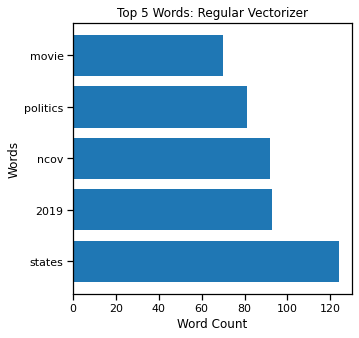

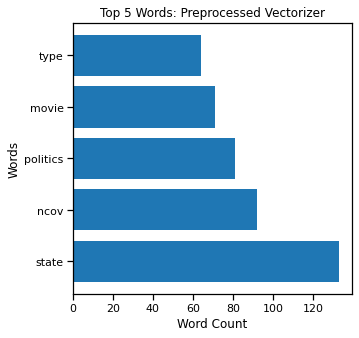

In [21]:
# regular vectorizer
keywords_cv, X_train_keywords_cv, X_test_keywords_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.keywords, X_test.keywords)
# smote vectorized training data
X_train_keywords_cv_sm, y_train_keywords_cv_sm = smote_data(X_train_keywords_cv, y_train, 
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_cv
# data: X_train_keywords_cv_sm, y_train_keywords_cv_sm, X_test_keywords_cv



# tokenize and lemmatize before vectorization
keywords_tok_cv, X_train_keywords_tok_cv, X_test_keywords_tok_cv = tokenize_vector(CountVectorizer, 
                                                                                   X_train.keywords, 
                                                                                   X_test.keywords)
# smote preprocessed vectorized training data
X_train_keywords_tok_cv_sm, y_train_keywords_tok_cv_sm = smote_data(X_train_keywords_tok_cv, y_train, 
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_tok_cv
# data: X_train_keywords_tok_cv_sm, y_train_keywords_tok_cv_sm, X_test_keywords_tok_cv

plot_top_words(keywords_cv, X_train_keywords_cv, 'Regular Vectorizer');
plot_top_words(keywords_tok_cv, X_train_keywords_tok_cv, 'Preprocessed Vectorizer');

### Snippet

##### TfidfVectorizer

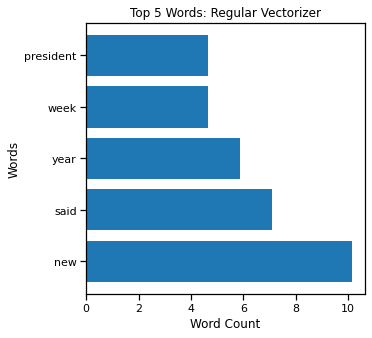

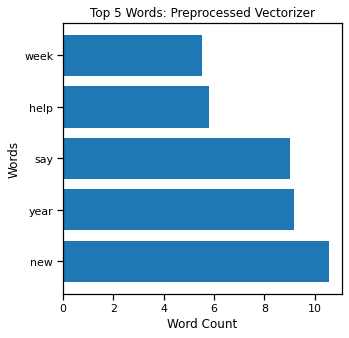

In [22]:
# regular vectorizer
snippet_tf, X_train_snippet_tf, X_test_snippet_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.snippet, X_test.snippet)
# smote vectorized training data
X_train_snippet_tf_sm, y_train_snippet_tf_sm = smote_data(X_train_snippet_tf, y_train, 
                                                          sampling_strategy='auto',random_state=0)

# used later
# vectorizor: snippet_tf
# data: X_train_snippet_tf_sm, y_train_snippet_tf_sm, X_test_snippet_tf



# tokenize and lemmatize before vectorization
snippet_tok_tf, X_train_snippet_tok_tf, X_test_snippet_tok_tf = tokenize_vector(TfidfVectorizer, 
                                                                                X_train.snippet, 
                                                                                X_test.snippet)
# smote preprocessed vectorized training data
X_train_snippet_tok_tf_sm, y_train_snippet_tok_tf_sm = smote_data(X_train_snippet_tok_tf, y_train, 
                                                                  sampling_strategy='auto',random_state=0)

# used later
# vectorizor: snippet_tok_tf
# data: X_train_snippet_tok_tf_sm, y_train_snippet_tok_tf_sm, X_test_snippet_tok_tf

plot_top_words(snippet_tf, X_train_snippet_tf, 'Regular Vectorizer');
plot_top_words(snippet_tok_tf, X_train_snippet_tok_tf, 'Preprocessed Vectorizer');

##### CountVectorizer

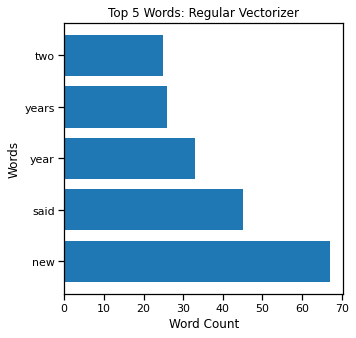

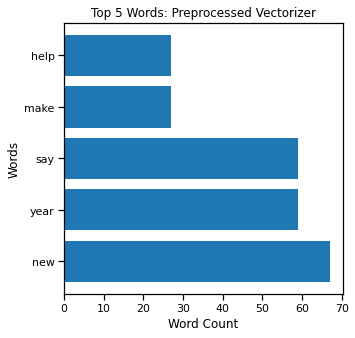

In [23]:
# regular vectorizer
snippet_cv, X_train_snippet_cv, X_test_snippet_cv = vectorize_feature(CountVectorizer,
                                                                      X_train.snippet, X_test.snippet)
# smote vectorized training data
X_train_snippet_cv_sm, y_train_snippet_cv_sm = smote_data(X_train_snippet_cv, y_train, 
                                                          sampling_strategy='auto', random_state=0)
# used later
# vectorizor: snippet_cv
# data: X_train_snippet_cv_sm, y_train_snippet_cv_sm, X_test_snippet_cv



# tokenize and lemmatize before vectorization
snippet_tok_cv, X_train_snippet_tok_cv, X_test_snippet_tok_cv = tokenize_vector(CountVectorizer, 
                                                                                X_train.snippet, 
                                                                                X_test.snippet)
# smote preprocessed vectorized training data
X_train_snippet_tok_cv_sm, y_train_snippet_tok_cv_sm = smote_data(X_train_snippet_tok_cv, y_train, 
                                                                  sampling_strategy='auto', random_state=0)
# used later
# vectorizor: snippet_tok_cv
# data: X_train_snippet_tok_cv_sm, y_train_snippet_tok_cv_sm, X_test_snippet_tok_cv

# plot 
plot_top_words(snippet_cv, X_train_snippet_cv, 'Regular Vectorizer');
plot_top_words(snippet_tok_cv, X_train_snippet_tok_cv, 'Preprocessed Vectorizer');

### Word Count

Since there is no preprocessing for the word count column, It only has to be SMOTEd before going through a model. 

In [24]:
# smote the word_count data
X_train_word_count_sm, y_train_word_count_sm = smote_data(X_train.word_count.values.reshape(-1, 1), y_train, 
                                                          sampling_strategy='auto', random_state=0)

<br>

## Modeling - Text Features

Each of the two different vectorized streams will go through different Random Forests. The streams that went through the TfidfVectorizer will go through a Random Forest that outputs the probability that the test is from an article on the most shared list, while the text that went through the CountVectorizer will go through a Random Forest that outputs a class label of 0 or 1  for that feature. This will translate each text feature into either a probability or a class label that will be fed into the final prediction model. 

##### Predict Proba Random Forest 

In [25]:
# function to run a random forrest 
# returns the model and a list of proabilities 
def random_forrest_proba(X_train, y_train, X_test, y_test):
    
    # initiate random forrest and search grid for number of trees in forrest
    forrest = RandomForestClassifier(random_state=0)
    grid = {'n_estimators': [50, 75, 100]}
    
    # create grid search and fit model with training data
    gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # store predicted probabilities that article is a popular article in a list 
    class_probability = gs.predict_proba(X_test)
    target_probability = [x[1] for x in class_probability]
    
    # print best params
    print(gs.best_estimator_)
    
    # print model accuracy 
    score = gs.score(X_test, y_test)
    print(f'mean accuracy: {score}')
    
    # print correlation
    print(f'correlation: {round(np.corrcoef(target_probability, y_test)[0][1], 2)}')
    
    # plot an ROC curve 
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(gs, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='Test', ax=ax)
    
    # plot confusion matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return gs, target_probability

##### Class Label Random Forest 

In [26]:
# function to run a random forrest 
# returns the model and a list of class labels 
def random_forrest_class(X_train, y_train, X_test, y_test):
    
    # initiate random forrest and search grid for number of trees in forrest
    forrest = RandomForestClassifier(random_state=0)
    grid = {'n_estimators': [50, 75, 100]}
    
    # create grid search and fit model with training data
    gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # store predicted class labels in list 
    class_prediction = gs.predict(X_test)
    
    # print best params
    print(gs.best_estimator_)
    
    # print model accuracy
    score = gs.score(X_test, y_test)
    print(f'mean accuracy: {score}')
    
    # print correlation
    print(f'correlation: {round(np.corrcoef(class_prediction, y_test)[0][1], 2)}')   
    
    # plot an ROC curve
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(gs, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='Test', ax=ax)
    
    # plot confusion matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return gs, class_prediction

<br>

Now to put the vectorized data through the modeling functions that will produce the model back and a list of either probabilities or class labels. This will be done twice for each feature. One for the regular vectorizer that only took out stop words, and one for the vectorizer that also went through lemmatization. 

### Headline

##### Predict Probability after TfidfVectorizer

RandomForestClassifier(random_state=0)
mean accuracy: 0.8766404199475065
correlation: 0.15
number of probabilities: 381



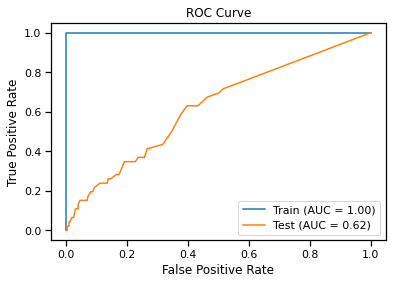

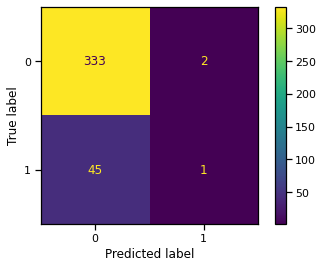

In [27]:
# run random forrest
headline_proba_rf, headline_proba = random_forrest_proba(X_train_headline_tf_sm, y_train_headline_tf_sm, 
                                                         X_test_headline_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(headline_proba)}')
print()

##### Predict Probability after Preprocessed TfidfVectorizer

RandomForestClassifier(n_estimators=75, random_state=0)
mean accuracy: 0.8792650918635171
correlation: 0.13
number of probabilities: 381



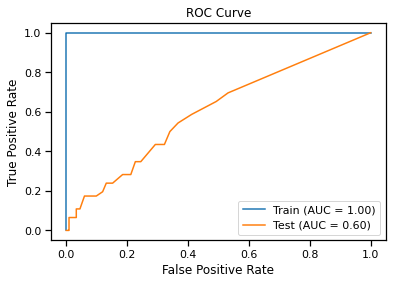

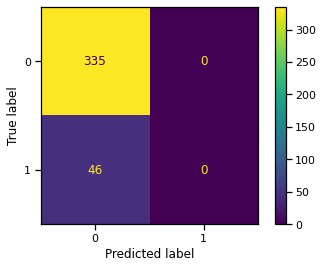

In [28]:
# run random forrest
headline_proba_rf_tok, headline_proba_tok = random_forrest_proba(X_train_headline_tok_tf_sm, 
                                                                 y_train_headline_tok_tf_sm,
                                                                 X_test_headline_tok_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(headline_proba_tok)}')
print()

##### Predict Class after CountVectorizer

RandomForestClassifier(random_state=0)
mean accuracy: 0.4645669291338583
correlation: -0.09
number of class predictions: 381



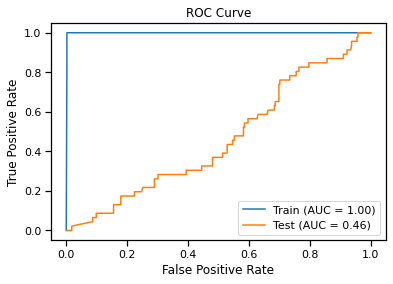

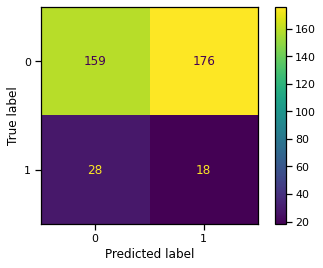

In [29]:
# run random forrest
headline_class_rf, headline_class = random_forrest_class(X_train_headline_cv_sm, y_train_headline_cv_sm, 
                                                         X_test_headline_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(headline_class)}')
print()

##### Predict Class after Preprocessed CountVectorizer

RandomForestClassifier(random_state=0)
mean accuracy: 0.4461942257217848
correlation: -0.08
number of class predictions: 381



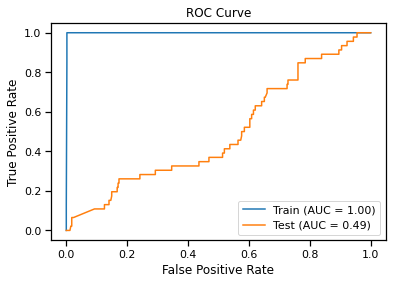

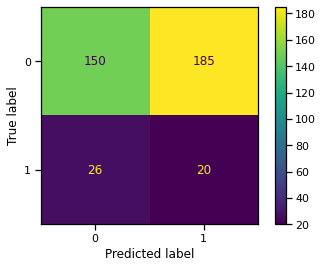

In [30]:
# run random forrest
headline_class_rf_tok, headline_class_tok = random_forrest_class(X_train_headline_tok_cv_sm, 
                                                                 y_train_headline_tok_cv_sm,
                                                                 X_test_headline_tok_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(headline_class_tok)}')
print()

##### Best performing headline models:
- TfidfVectorizer
    - headline_tf (regular vectorizer) 
    - headline_proba_rf (trained on regular vectorizer)
- CountVectorizer
    - headline_cv (regular vectorizer)
    - headline_class_rf (trained on regular vectorizer)

### Keywords

##### Predict Probability after TfidfVectorizer

RandomForestClassifier(random_state=0)
mean accuracy: 0.8792650918635171
correlation: 0.18
number of probabilities: 381



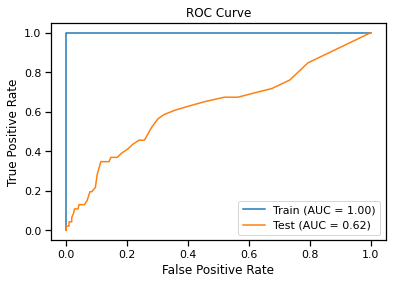

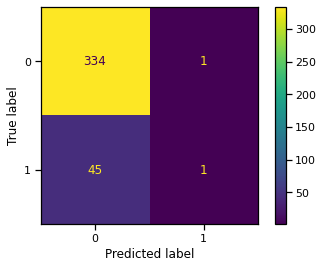

In [31]:
# run random forrest
keywords_proba_rf, keywords_proba = random_forrest_proba(X_train_keywords_tf_sm, y_train_keywords_tf_sm, 
                                                         X_test_keywords_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(keywords_proba)}')
print()

##### Predict Probability after Preprocessed TfidfVectorizer

RandomForestClassifier(n_estimators=75, random_state=0)
mean accuracy: 0.8818897637795275
correlation: 0.2
number of probabilities: 381



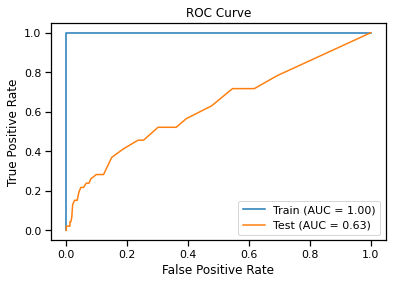

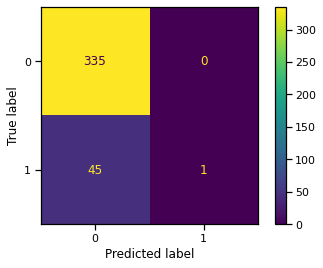

In [32]:
# run random forrest
keywords_proba_rf_tok, keywords_proba_tok = random_forrest_proba(X_train_keywords_tok_tf_sm, 
                                                                 y_train_keywords_tok_tf_sm, 
                                                                 X_test_keywords_tok_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(keywords_proba_tok)}')
print()

##### Predict Class after CountVectorizer

RandomForestClassifier(n_estimators=50, random_state=0)
mean accuracy: 0.5590551181102362
correlation: -0.02
number of class predictions: 381



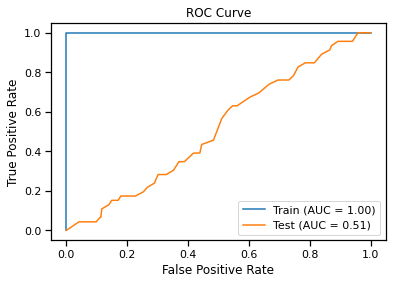

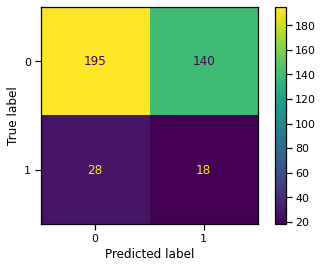

In [33]:
# run random forrest
keywords_class_rf, keywords_class = random_forrest_class(X_train_keywords_cv_sm, y_train_keywords_cv_sm, 
                                                         X_test_keywords_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(keywords_class)}')
print()

##### Predict Class after Preprocessed CountVectorizer

RandomForestClassifier(n_estimators=50, random_state=0)
mean accuracy: 0.48031496062992124
correlation: -0.0
number of class predictions: 381



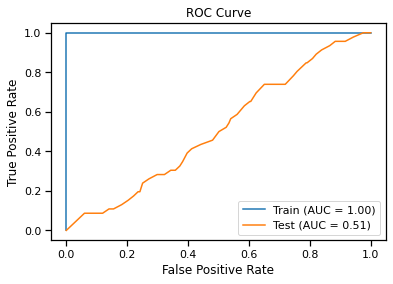

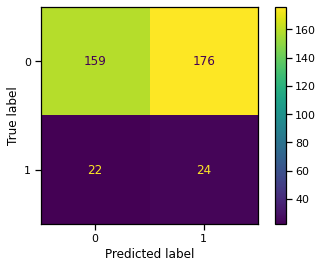

In [34]:
# run random forrest
keywords_class_rf_tok, keywords_class_tok = random_forrest_class(X_train_keywords_tok_cv_sm, 
                                                                 y_train_keywords_tok_cv_sm, 
                                                                 X_test_keywords_tok_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(keywords_class_tok)}')
print()

##### Best performing keywords models:
- TfidfVectorizer
    - keywords_tf (regular vectorizer) 
    - keywords_proba_rf (trained on regular vectorizer)
- CountVectorizer
    - keywords_cv (regular vectorizer)
    - keywords_class_rf (trained on regular vectorizer)

### Snippet 

##### Predict Probability after TfidfVectorizer

RandomForestClassifier(n_estimators=50, random_state=0)
mean accuracy: 0.8792650918635171
correlation: 0.13
number of probabilities: 381



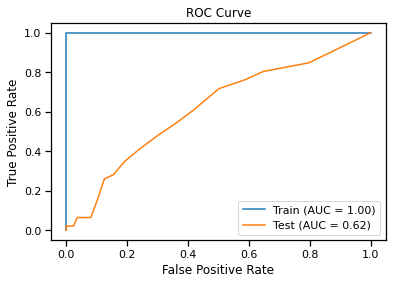

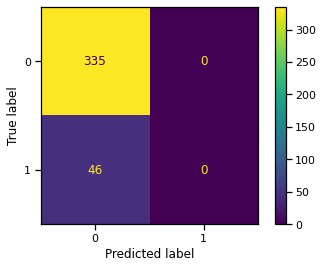

In [35]:
# run random forrest
snippet_proba_rf, snippet_proba = random_forrest_proba(X_train_snippet_tf_sm, y_train_snippet_tf_sm, 
                                                       X_test_snippet_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(snippet_proba)}')
print()

##### Predict Probability after Preprocessed TfidfVectorizer

RandomForestClassifier(n_estimators=75, random_state=0)
mean accuracy: 0.8792650918635171
correlation: 0.13
number of probabilities: 381



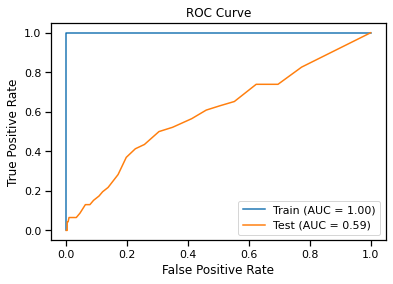

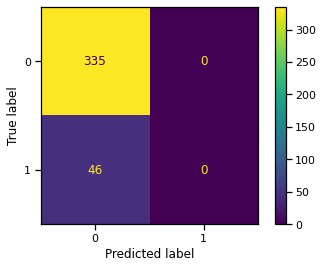

In [36]:
# run random forrest
snippet_proba_rf_tok, snippet_proba_tok = random_forrest_proba(X_train_snippet_tok_tf_sm, 
                                                               y_train_snippet_tok_tf_sm,
                                                               X_test_snippet_tok_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(snippet_proba_tok)}')
print()

##### Predict Class after CountVectorizer

RandomForestClassifier(random_state=0)
mean accuracy: 0.5564304461942258
correlation: -0.01
number of class predictions: 381



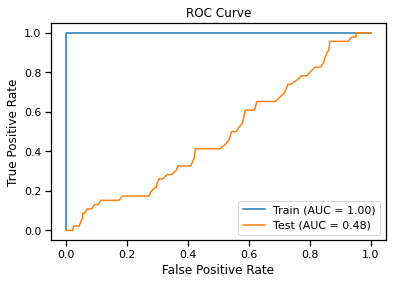

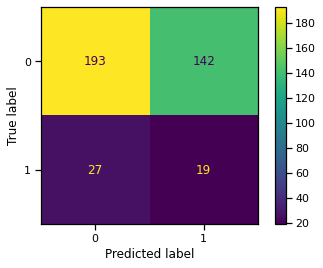

In [37]:
# run random forrest
snippet_class_rf, snippet_class = random_forrest_class(X_train_snippet_cv_sm, y_train_snippet_cv_sm, 
                                                       X_test_snippet_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(snippet_class)}')
print()

##### Predict Class after Preprocessed CountVectorizer

RandomForestClassifier(n_estimators=50, random_state=0)
mean accuracy: 0.5196850393700787
correlation: 0.01
number of class predictions: 381



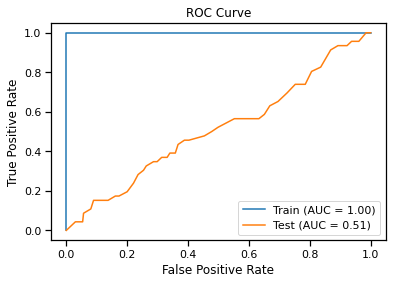

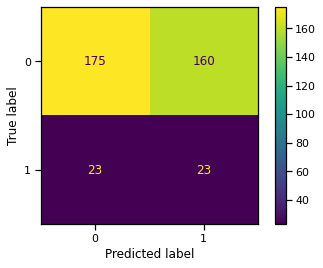

In [38]:
# run random forrest
snippet_class_rf_tok, snippet_class_tok = random_forrest_class(X_train_snippet_tok_cv_sm, 
                                                               y_train_snippet_tok_cv_sm,
                                                               X_test_snippet_tok_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(snippet_class_tok)}')
print()

##### Best performing snippet models:
- TfidfVectorizer
    - snippet_tok_tf (lemmatized vectorizer)
    - snippet_proba_rf_tok (trained on lemmatized vectorizer)
- CountVectorizer
    - snippet_tok_cv (lemmatized vectorizer)
    - snippet_class_rf_tok (trained on lemmatized vectorizer)

## Model Training - Numeric

The word count feature will go through a logistic regression model that will produce the model back out, a predict proba for the probability stream and a class label for binary stream.

##### Predict Proba and Predict class 

In [39]:
# function to run a logistic regression 
# returns the model, a list of proabilities, and a list of class labels 
def log_regression_word_count(X_train, y_train, X_test, y_test):
    
    
    # initiate logsitic regression and fit with training data 
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, y_train)
    
    # store predicted class labels in list 
    class_prediction = clf.predict(X_test.values.reshape(-1, 1))
    
    # store predicted probabilities that article is a popular article in a list
    probabilities = clf.predict_proba(X_test.values.reshape(-1, 1))
    probabilities = [x[1] for x in probabilities]
    
    # print model accuracy
    score = clf.score(X_test.values.reshape(-1, 1), y_test)
    print(f'mean accuracy: {score}')
    
    # print correlation
    print(f'class correlation: {round(np.corrcoef(class_prediction, y_test)[0][1], 2)}') 
    print(f'proba correlation: {round(np.corrcoef(probabilities, y_test)[0][1], 2)}')
    
    # plot an ROC curve
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(clf, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(clf, X_test.values.reshape(-1, 1), y_test, name='Test', ax=ax);
    
    # plot confusion matrix
    plot_confusion_matrix(clf, X_test.values.reshape(-1, 1), y_test)
    
    return clf, probabilities, class_prediction

<br>
The SMOTEd word count training and normally sampeled testing data is passed through the Logistic Regression model. 

mean accuracy: 0.5669291338582677
class correlation: 0.04
proba correlation: 0.06
number of probabilities: 381
number of class predictions: 381



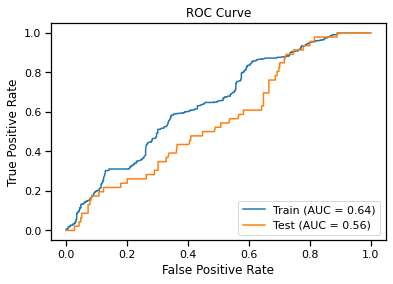

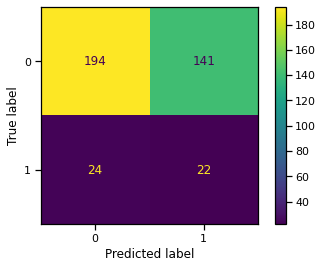

In [40]:
# run logistic regression
word_count_log_reg, word_count_proba, word_count_class = log_regression_word_count(X_train_word_count_sm, 
                                                                                   y_train_word_count_sm, 
                                                                                   X_test.word_count, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(word_count_proba)}')
print(f'number of class predictions: {len(word_count_class)}')
print()

## Cumulative Model 

Now all the features from the test set that have been converted into either probabilities or class labels can be brought back together into a new data frame so the cumulative logistic regression model can be trained. This will be the final model that the  deployed data goes through to predict each day's top 20 list. This final model will predict probabilities with both the probability pipeline and the class pipeline. 

### Rejoining Data
The test results of the features for both the TfidfVectorizer that produces probabilities of the article being a most shared article and the CountVectorizer that produces binary class labels are put back together after being run through their different models. The TfidfVectorized features go through the extra step of being normalized with sklearn's `StandardScaler()`.

##### Proability Data

In [41]:
# joining predictions into DataFrame
df_predict_proba = pd.DataFrame({'headline_prob': headline_proba, 
                                 'keywords_prob': keywords_proba, 
                                 'snippet_prob': snippet_proba_tok,
                                 'word_count_prob': word_count_proba})

scaler = StandardScaler()
df_predict_proba.iloc[:,:] = scaler.fit_transform(df_predict_proba.iloc[:,:].to_numpy())

In [42]:
df_predict_proba.head()

,headline_prob,keywords_prob,snippet_prob,word_count_prob
0,0.589269,2.635401,-0.997263,0.541363
1,0.072953,-0.615931,-0.997263,1.514048
2,-0.701522,0.722853,-0.546186,-0.118185
3,-0.701522,-0.902813,-0.245468,0.106046
4,-0.013100,-0.520303,0.656686,-0.566050


<br>

##### Class Labeled Data 

In [43]:
# joining predictions into DataFrame
df_predict_class = pd.DataFrame({'headline_class': headline_class, 
                                 'keywords_class': keywords_class, 
                                 'snippet_class_tok': snippet_class_tok,
                                 'word_count_class': word_count_class})

In [44]:
df_predict_class.head()

,headline_class,keywords_class,snippet_class_tok,word_count_class
0,0,0,1,1
1,0,0,0,1
2,1,1,1,0
3,1,0,1,0
4,1,1,0,0


,sum,percentage
popular,,
0,335,0.88
1,46,0.12


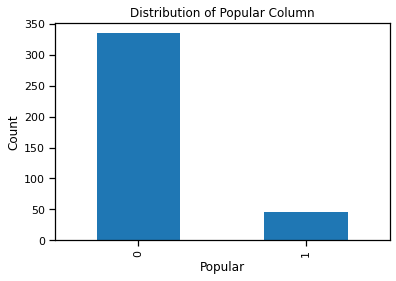

In [45]:
target_distribution_deploy = summerize_value_counts(y_test)
target_distribution_deploy

<br>

### Training model

Training the final model on the rejoined processed data. 



##### Predicting with Probabilities 

In [46]:
clf_proba = LogisticRegression()

In [47]:
clf_proba.fit(df_predict_proba, y_test)

LogisticRegression()

<br>

##### Predicitng with class labels

In [48]:
clf_class = LogisticRegression()

In [49]:
clf_class.fit(df_predict_class, y_test)

LogisticRegression()

## Model Deployment Test
Uncomment code to run on new day o Deployemnt.

To deploy the pipeline, a new top 20 list is grabbed from the NTY API and Articles from the archive from two days before the day of prediction are chosen. Those archive articles are sent through both the probability pipeline and the class labeling pipeline, which are then sent through the final model to predict a final probability for both streams that each article will be on that day's top 20. Those probabilities are then sorted from highest to lowest, with the top 20 representing that pipeline's top 20 list for comparison with the actual top 20 list for that day.  

<br>
Grab deployemnt data

In [50]:
df_archive_deploy = pd.read_csv('data/archive_deploy.csv')
df_archive_deploy.date_published = df_archive_deploy.date_published.apply(lambda x: pd.to_datetime(x).date())
df_archive_deploy.dropna(inplace=True)

df_most_shared_deploy = load_most_shared('data/most_popular_deploy')

<br>
Setting a prediction day variable and converting it to datetime datatype.   

In [51]:
prediction_day = ''
prediction_day = pd.to_datetime(prediction_day).date()
prediction_day

NaT

Creating a function that will return the day's prediction dataframe into article ids, the date published, the features for the pipeline and that day's top 20. 

In [52]:
def filter_predction_dfs(df_archive, df_shared, day_of_predict, delta=2):
    
    time_delta = dt.timedelta(days=delta)
    cutoff_day = day_of_predict - time_delta
    
    df_deploy = df_archive[(df_archive.date_published >= cutoff_day) & 
                             (df_archive.date_published < day_of_predict)]
    
    article_ids = df_deploy['uri']
    date_published = df_deploy['date_published']
    df_feature_deploy = df_deploy[['headline','keywords','snippet', 'word_count']]
    
    df_top_20 = df_shared[df_shared.index == day_of_predict]
    
    return article_ids, date_published, df_feature_deploy, df_top_20

Pass the day's prediction data through the filtering function. 

In [53]:
deployed_article_ids, date_published, df_feature_deploy, df_top_20 = filter_predction_dfs(df_archive_deploy, 
                                                                          df_most_shared_deploy, 
                                                                          prediction_day, delta=2)

<br>
Creating two separate pipelines for each feature, one for the best performing preprocessing for the probability stream and one for the best performing stream for the class labeling pipeline.

In [54]:
headline_proba_pipe = Pipeline([('headline_tf', headline_tf), 
                                ('headline_proba_rf', headline_proba_rf)])

keywords_proba_pipe = Pipeline([('keywords_tf', keywords_tf), 
                                ('keywords_proba_rf', keywords_proba_rf)])

snippet_proba_pipe = Pipeline([('snippet_tok_tf', snippet_tok_tf), 
                               ('snippet_proba_rf_tok', snippet_proba_rf_tok)])

In [55]:
headline_class_pipe = Pipeline([('headline_cv', headline_cv), 
                                ('headline_class_rf', headline_class_rf)])

keywords_class_pipe = Pipeline([('keywords_cv', keywords_cv), 
                                ('keywords_class_rf', keywords_class_rf)])

snippet_class_pipe = Pipeline([('snippet_tok_cv', snippet_tok_cv), 
                               ('snippet_class_rf_tok', snippet_class_rf_tok)])

These functions will run the day's prediction data through the respective pipeline's and combine the results into a dataframe. 

In [56]:
def proba_nlp_pipeline(features, index):
    
    headline_probs = headline_proba_pipe.predict_proba(features.headline)
    headline_probs = [x[1] for x in headline_probs]
    
    keywords_probs = keywords_proba_pipe.predict_proba(features.keywords)
    keywords_probs = [x[1] for x in keywords_probs]
    
    snippet_probs  = snippet_proba_pipe.predict_proba(features.snippet)
    snippet_probs = [x[1] for x in snippet_probs]
    
    word_count_probs = word_count_log_reg.predict_proba(features.word_count.values.reshape(-1, 1))
    word_count_probs = [x[1] for x in word_count_probs] 
    
    df = pd.DataFrame({'headline_probabilty': headline_probs, 
                       'keywords_probabilty': keywords_probs,
                       'snippet_probabilty': snippet_probs,
                       'word_count_probabilty': word_count_probs}, index=index)
        
    scaler = StandardScaler()
    df.iloc[:, :] = scaler.fit_transform(df.iloc[:, :].to_numpy())
    
    return df

In [57]:
def class_nlp_pipeline(features, index):
    
    headline_probs = headline_class_pipe.predict(features.headline)
    keywords_probs = keywords_class_pipe.predict(features.keywords)
    snippet_probs  = snippet_class_pipe.predict(features.snippet)
    word_count_probs = word_count_log_reg.predict(features.word_count.values.reshape(-1, 1))
    
    df = pd.DataFrame({'headline_probabilty': headline_probs, 
                       'keywords_probabilty': keywords_probs, 
                       'snippet_probabilty': snippet_probs,
                       'word_count_probabilty': word_count_probs},  index=index)
        
    return df

Run probability pipeline function and pass new dataframe into final logistic regression model.

In [58]:
# proba_for_pred = proba_nlp_pipeline(df_feature_deploy, df_feature_deploy.index)

In [59]:
# proba_for_pred.head()

In [60]:
# predictions_from_proba = clf_proba.predict_proba(proba_for_pred)
# predictions_from_proba = [x[1] for x in predictions_from_proba]
# predictions_from_proba = pd.Series(predictions_from_proba, index=deployed_article_ids.index, 
#                                    name='predictions_from_proba')

Run class labeling pipeline function and pass new data frame through final logistic regression model. 

In [61]:
# class_for_pred = class_nlp_pipeline(df_feature_deploy, df_feature_deploy.index)

In [62]:
# class_for_pred.head()

In [63]:
# predictions_from_class = clf_class.predict_proba(class_for_pred)
# predictions_from_class = [x[1] for x in predictions_from_class]
# predictions_from_class = pd.Series(predictions_from_class, index=deployed_article_ids.index,
#                                    name='predictions_from_class')

<br>
creating a top 20 for the probability pipeline 

In [64]:
# top_20_from_proba = pd.DataFrame([deployed_article_ids, date_published, predictions_from_proba]).T

# top_20_from_proba.sort_values('predictions_from_proba', ascending=False, inplace=True) 
# top_20_from_proba = top_20_from_proba[:20]
# top_20_from_proba

<br>
creating a top 20 for the probability pipeline 

In [65]:
# top_20_from_class = pd.DataFrame([deployed_article_ids, date_published, predictions_from_class]).T


# top_20_from_class.sort_values('predictions_from_class', ascending=False, inplace=True)
# top_20_from_class = top_20_from_class[:20]
# top_20_from_class

<br>
This function will take the top 20 from both pipelines and calculate the proportion of articles that were on each day's top 20 lists. Passing it through to a DataFrame constructor and transforming it gives us the day's prediction score. 

In [66]:
# prediction_df = pd.DataFrame(score_top20_pred(top_20_from_proba, top_20_from_class, df_top_20)).T
# prediction_df

<br>
Each day's predction results get saved to their on file.

In [67]:
# file_date = prediction_df.index[0].replace('-', '_')
# prediction_df.to_csv(f'data/predictions/pred_for_{file_date}.csv')

<br>
Now a custom function will grab all prediction days results which will then go through another custom function to plot each day's results. 

In [68]:
current_pred_results = load_predictions('data/predictions/')
current_pred_results.sort_index(inplace=True)
current_pred_results.loc['Average'] = round(current_pred_results[['proba_tf_pipe','class_cv_pipe']].mean(), 2)
current_pred_results

,proba_tf_pipe,class_cv_pipe
date,,
2022-01-19,0.10,0.00
2022-01-20,0.15,0.05
2022-01-22,0.10,0.00
2022-01-23,0.15,0.10
2022-01-24,0.20,0.05
2022-01-25,0.30,0.10
Average,0.17,0.05


In [69]:
def plot_predictions(df):

    proba_tf_pipe = df.proba_tf_pipe
    class_cv_pipe = df.class_cv_pipe
    df = pd.DataFrame({'Tfidf Pipeline': df.proba_tf_pipe, 'CountVectorizer Pipeline': df.class_cv_pipe})

    ax = df.plot.bar(color=['SkyBlue','IndianRed'], rot=45, title='Too 20 Articles Predictions', 
                     figsize=(10,10), fontsize=15)
    
    ax.set_title('Too 20 Articles Predictions', fontsize=20)
    ax.set_xlabel('Prediction Day', fontsize=20)
    ax.set_ylabel('Percentage Correct', fontsize=20)
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5], 
                   ['0%', '10%', '20%', '30%', '40%', '50%'])

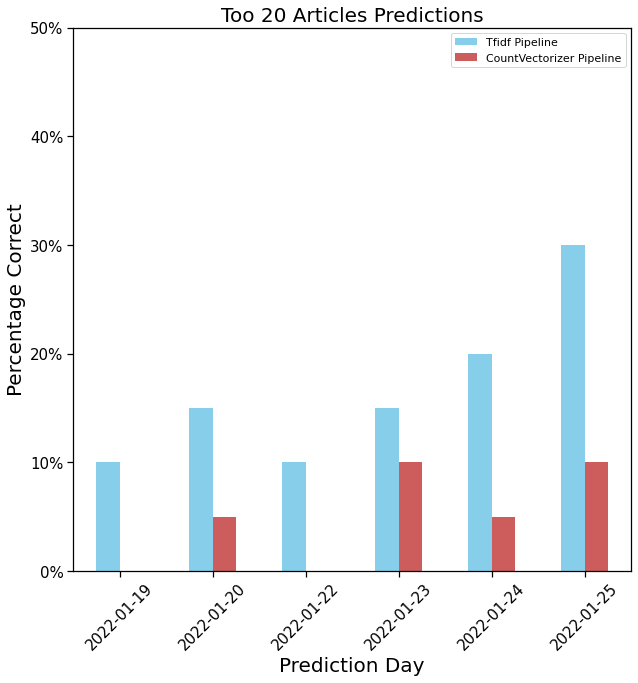

In [70]:
plot_predictions(current_pred_results[:-1]);

In [71]:
print(f"""
Proability pipeline results: {round(current_pred_results.proba_tf_pipe.mean(), 2)}
Class label pipeline results: {round(current_pred_results.class_cv_pipe.mean(), 2)}
""")


Proability pipeline results: 0.17
Class label pipeline results: 0.05



## Evaluation

Both model pipelines were insufficient to produce a top 20 that matched the actual top 20, with the class labeling pipeline only producing an average 5% accuracy and the probability pipeline beating that with a 17% accuracy. This is a fine start towards modeling the top 20 list with NLP, but more steps will have to be taken in order to get the final top 20 lists closer towards 50%, or correctly prediction 10/20 top articles. This includes training the models on daily top 20 list for a longer period of time and running feed back to the culmlative logistic regression model based on each days results. 